In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# from sklearn.decomposition import PCA
from scipy import stats
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.metrics import davies_bouldin_score

import pickle
import copy
# from shapely import geometry
# from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
# from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# from scipy.stats import ks_2samp

In [2]:
import string
abcd = list(string.ascii_lowercase)

In [3]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [4]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'../ProcessZ500/labels/df_labels_nocorrfilt_{reanalysis}.csv', parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp = labels_temp['1948':]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels[reanalysis] = labels_temp

In [5]:
dic_events = {}

for ir, reanalysis in enumerate(names_reanalyses):
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels[reanalysis])
    
    df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_labels['season'] = df_labels['season'].map(season_map)
    
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events[reanalysis] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/2337241071.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/2337241071.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/2337241071.py:16: FutureWarning: A value

In [6]:
N=30

dic_stats_durations = {}
dic_dfs_durations = {}

for ir, reanalysis in enumerate(names_reanalyses):
    dic_stats_durations[reanalysis] = {}
    dic_dfs_durations[reanalysis] = {}
    start_year = dic_labels[reanalysis].index.year[0] + (N-1)
    end_year = dic_labels[reanalysis].index.year[-1]
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events[reanalysis])
        df_temp = df_temp[(df_temp['season']=='Winter')|(df_temp['season']=='Spring')]
        df_temp = df_temp[df_temp['WR']==wr]
        
        dic_stats_temp = {}
        dic_stats_temp['mean'] = []
        dic_stats_temp['std'] = []
        dic_stats_temp['p90'] = []
        dic_stats_temp['p10'] = []
        dic_stats_temp['p95'] = []
        dic_stats_temp['p05'] = []
        dic_stats_temp['n_events'] = []
        dic_stats_temp['n_days'] = []
        
        for year in range(start_year, end_year+1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp)/30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum()/(30*365/2))
        df_stats_temp = pd.DataFrame(dic_stats_temp,index=np.arange(start_year,end_year+1))
        df_stats_temp.index = df_stats_temp.index-15
        dic_stats_durations[reanalysis][f'wr{wr}'] = df_stats_temp
        dic_dfs_durations[reanalysis][f'wr{wr}'] = df_temp

In [7]:
files_lens2 = np.sort(glob.glob('../ProcessZ500/labels_lens2/*.csv'))

dic_labels_lens2 = {}

for file_temp in files_lens2:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_lens2[file_temp.split('labels_')[-1][:-4]] = labels_temp

dic_events_lens2 = {}

for file_temp in files_lens2:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_lens2[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_lens2[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/2115786177.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/2115786177.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/2115786177.py:25: FutureWarning: A value

In [8]:
files_e3smv2 = np.sort(glob.glob('../ProcessZ500/labels_e3smv2/*.csv'))

dic_labels_e3smv2 = {}

for file_temp in files_e3smv2:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_e3smv2[file_temp.split('labels_')[-1][:-4]] = labels_temp

dic_events_e3smv2 = {}

for file_temp in files_e3smv2:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_e3smv2[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_e3smv2[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/1954339532.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/1954339532.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/1954339532.py:25: FutureWarning: A value

In [9]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_lens2[key].index.year[0] + (N-1)
    end_year = dic_labels_lens2[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_lens2[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        df_stats_temp.index=df_stats_temp.index-15
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_lens2 = {}
    dic_dfs_durations_lens2 = {}

    with Pool() as pool:
        results = pool.map(process_file, files_lens2)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_lens2[key] = dic_stats
        dic_dfs_durations_lens2[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

../ProcessZ500/labels_lens2/df_labels_LE2-1021.002_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1031.002_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1041.003_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1051.003_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1061.004_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1071.004_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1081.005_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1091.005_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1101.006_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1111.006_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1121.007_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1131.007_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1141.008_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1151.008_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1161.009_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1171.009_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1181.0

In [10]:
names_models = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_lens2])

In [11]:
wr = 1

In [12]:
lens2listfreqsfull = []
for name_model in names_models:
    lens2listfreqsfull.append(dic_stats_durations_lens2[name_model][f'wr{wr}']['n_days'].values)

meanlens2 = pd.Series(np.mean(lens2listfreqsfull,axis=0),index=dic_stats_durations_lens2[name_model][f'wr{wr}'].index)

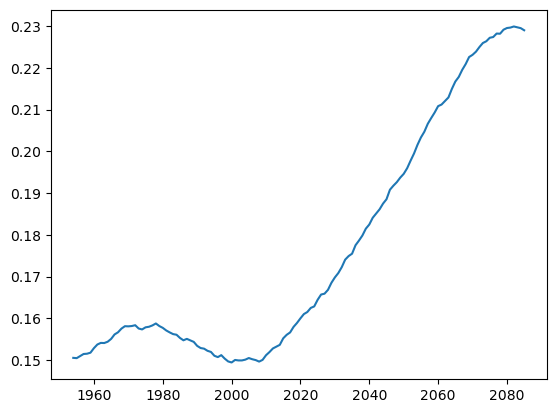

In [13]:
plt.plot(meanlens2)

In [14]:
# meanlens2.to_csv('meanlens2.csv')

In [15]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file_e3smv2(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_e3smv2[key].index.year[0] + (N-1)
    end_year = dic_labels_e3smv2[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_e3smv2[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))
            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        df_stats_temp.index=df_stats_temp.index-15
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_e3smv2 = {}
    dic_dfs_durations_e3smv2 = {}

    with Pool() as pool:
        results = pool.map(process_file_e3smv2, files_e3smv2)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_e3smv2[key] = dic_stats
        dic_dfs_durations_e3smv2[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

names_models_e3smv2 = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_e3smv2])

../ProcessZ500/labels_e3smv2/df_labels_cmip6_0131.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0141.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0161.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0171.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0181.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0191.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0211.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0221.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0231.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0241.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0261.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0271.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0281.csv../ProcessZ500/labels_e3smv2/df_labels_cmip6_0291.csv../ProcessZ500/labels_e3smv2/df_labels_smbb_0101.csv../ProcessZ500/labels_e3smv2/df_labels_smbb_0111.csv../ProcessZ500/labels_e3smv2/df_labels_smbb_0121.csv../ProcessZ500/labels_e3smv2/df_labels_smbb_0131.csv../ProcessZ500/labels_e3smv2/df_labels_smbb_0141.c

In [16]:
wr = 1
e3smv2listfreqsfull = []
for name_model in names_models_e3smv2:
    e3smv2listfreqsfull.append(dic_stats_durations_e3smv2[name_model][f'wr{wr}']['n_days'])

meane3smv2 = pd.concat(e3smv2listfreqsfull,axis=1).mean(axis=1)

In [17]:
for name_model in names_models_e3smv2:
    print(dic_stats_durations_e3smv2[name_model][f'wr{wr}']['n_days'].index[0],dic_stats_durations_e3smv2[name_model][f'wr{wr}']['n_days'].index[-1])

1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
1954 2085
2004 2070
2005 2070
2005 2070
2005 2070
2005 2070
2004 2070
2005 2070
2005 2070
2005 2070
2005 2070
2004 2070
2005 2070
2005 2070
2005 2070
2005 2070
2004 2070
2005 2070
2005 2070
2005 2070
2004 2070


In [18]:
print(dic_stats_durations_e3smv2[name_model][f'wr{wr}']['n_days'].index[0],dic_stats_durations_e3smv2[name_model][f'wr{wr}']['n_days'].index[-1])

2004 2070


In [19]:
colors_reanalyses = {'ERA5':'k','JRA3Q':'red','NCEP_NCAR':'blue'}

diffs_lens_past = []
diffs_lens_future = []

start_year = 1977-15
end_year = 2023-15

end_year_future = 2023+46-15
start_year_future = end_year_future - (end_year-start_year)
print(start_year_future)
for name_temp in names_models:
    df_stats_temp = dic_stats_durations_lens2[name_temp][f'wr{wr}']
    diffs_lens_past.append(df_stats_temp['n_days'][end_year]-df_stats_temp['n_days'][start_year])
    diffs_lens_future.append(df_stats_temp['n_days'][end_year_future]-df_stats_temp['n_days'][start_year_future])
diffs_lens_past = np.array(diffs_lens_past)
diffs_lens_future = np.array(diffs_lens_future)

diffs_e3sm_past = []
diffs_e3sm_future = []

start_year = 1977-15
end_year = 2023-15

end_year_future = 2023+46-15
start_year_future = end_year_future - (end_year-start_year)
print(start_year_future)
for name_temp in names_models_e3smv2:
    df_stats_temp = dic_stats_durations_e3smv2[name_temp][f'wr{wr}']
    if 'cmip6' in name_temp:
        diffs_e3sm_past.append(df_stats_temp['n_days'][end_year]-df_stats_temp['n_days'][start_year])
    diffs_e3sm_future.append(df_stats_temp['n_days'][end_year_future]-df_stats_temp['n_days'][start_year_future])
diffs_e3sm_past = np.array(diffs_e3sm_past)
diffs_e3sm_future = np.array(diffs_e3sm_future)

2008
2008


# Single forcing stuff

In [20]:
files_lens2_sf = np.sort(glob.glob('../ProcessZ500/labels_lens2_sf/*.csv'))

dic_labels_lens2_sf = {}

for file_temp in files_lens2_sf:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_lens2_sf[file_temp.split('labels_')[-1][:-4]] = labels_temp

dic_events_lens2_sf = {}

for file_temp in files_lens2_sf:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_lens2_sf[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_lens2_sf[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/166712528.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/166712528.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/166712528.py:25: FutureWarning: A value is

In [21]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file_sf(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_lens2_sf[key].index.year[0] + (N-1)
    end_year = dic_labels_lens2_sf[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_lens2_sf[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))
            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        df_stats_temp.index=df_stats_temp.index-15
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_lens2_sf = {}
    dic_dfs_durations_lens2_sf = {}

    with Pool() as pool:
        results = pool.map(process_file_sf, files_lens2_sf)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_lens2_sf[key] = dic_stats
        dic_dfs_durations_lens2_sf[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

../ProcessZ500/labels_lens2_sf/df_labels_AAER.003.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.004.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.005.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.006.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.007.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.008.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.009.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.010.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.011.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.012.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.013.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.014.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.015.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.016.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.017.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.018.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.019.csv../ProcessZ500/labels_lens2_sf/df_labels_AAER.020.csv../ProcessZ500/labels_lens2_sf/df_labels_BMB.0

In [22]:
names_models_sf = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_lens2_sf])

In [23]:
dic_diffs_forcings_past = {}
dic_diffs_forcings_future = {}
for iforcing,forcing in enumerate(['AAER','GHG','BMB','EE']):
    diffs_lens_sf_past = []
    diffs_lens_sf_future = []
    
    start_year = 1977-15
    end_year = 2023-15
    
    end_year_future = 2050-15
    start_year_future = end_year_future - (end_year-start_year)
    
    print(start_year_future)
    for name_temp in names_models_sf:
        if forcing in name_temp:
            df_stats_temp = dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']
            diffs_lens_sf_past.append(df_stats_temp['n_days'][end_year]-df_stats_temp['n_days'][start_year])
            diffs_lens_sf_future.append(df_stats_temp['n_days'][end_year_future]-df_stats_temp['n_days'][start_year_future])
    diffs_lens_sf_past = np.array(diffs_lens_sf_past)
    diffs_lens_sf_future = np.array(diffs_lens_sf_future)

    dic_diffs_forcings_past[forcing] = diffs_lens_sf_past
    dic_diffs_forcings_future[forcing] = diffs_lens_sf_future

1989
1989
1989
1989


In [1]:
1989-15

1974

In [24]:
names_models_sf

array(['AAER.001', 'AAER.002', 'AAER.003', 'AAER.004', 'AAER.005',
       'AAER.006', 'AAER.007', 'AAER.008', 'AAER.009', 'AAER.010',
       'AAER.011', 'AAER.012', 'AAER.013', 'AAER.014', 'AAER.015',
       'AAER.016', 'AAER.017', 'AAER.018', 'AAER.019', 'AAER.020',
       'BMB.001', 'BMB.002', 'BMB.003', 'BMB.004', 'BMB.005', 'BMB.006',
       'BMB.007', 'BMB.008', 'BMB.009', 'BMB.010', 'BMB.011', 'BMB.012',
       'BMB.013', 'BMB.014', 'BMB.015', 'EE.101', 'EE.102', 'EE.103',
       'EE.104', 'EE.105', 'EE.106', 'EE.107', 'EE.108', 'EE.109',
       'EE.110', 'EE.111', 'EE.112', 'EE.113', 'EE.114', 'EE.115',
       'GHG.001', 'GHG.002', 'GHG.003', 'GHG.004', 'GHG.005', 'GHG.006',
       'GHG.007', 'GHG.008', 'GHG.009', 'GHG.010', 'GHG.011', 'GHG.012',
       'GHG.013', 'GHG.014', 'GHG.015'], dtype='<U8')

In [25]:
ghgsffreqsfull = []
for nametemp in names_models_sf:
    if 'GHG' in nametemp:
        ghgsffreqsfull.append(dic_stats_durations_lens2_sf[nametemp][f'wr{wr}']['n_days'].values)

meanghg = pd.Series(np.mean(ghgsffreqsfull,axis=0),index=dic_stats_durations_lens2_sf[nametemp][f'wr{wr}'].index)

In [26]:
aersffreqsfull = []
for nametemp in names_models_sf:
    if 'AAER' in nametemp:
        aersffreqsfull.append(dic_stats_durations_lens2_sf[nametemp][f'wr{wr}']['n_days'].values)

meanaer = pd.Series(np.mean(aersffreqsfull,axis=0),index=dic_stats_durations_lens2_sf[nametemp][f'wr{wr}'].index)

In [27]:
bmbffreqsfull = []
for nametemp in names_models_sf:
    if 'BMB' in nametemp:
        bmbffreqsfull.append(dic_stats_durations_lens2_sf[nametemp][f'wr{wr}']['n_days'].values)

meanbmb = pd.Series(np.mean(bmbffreqsfull,axis=0),index=dic_stats_durations_lens2_sf[nametemp][f'wr{wr}'].index)

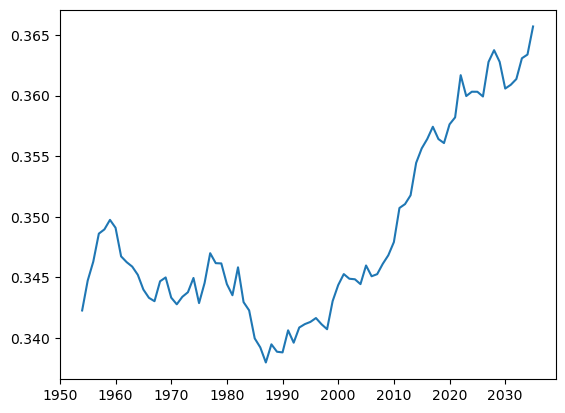

In [28]:
# plt.plot(meanghg)
# plt.plot(meanaer)
plt.plot(meanghg+meanaer)
# meanghg.to_csv('meanghg.csv')
# meanaer.to_csv('meanaer.csv')

# Single forcing stuff e3smv2

In [29]:
files_e3smv2_sf = np.sort(glob.glob('../ProcessZ500/labels_e3smv2_sf/*.csv'))

dic_labels_e3smv2_sf = {}

for file_temp in files_e3smv2_sf:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    name_temp_exp = file_temp.split('labels_')[-1][:-4].split('-')[-1]
    name_temp_exp = name_temp_exp.replace('_','.')
    name_temp_exp = name_temp_exp.replace('xaer','EE')
    name_temp_exp = name_temp_exp.replace('aer','AAER')
    dic_labels_e3smv2_sf[name_temp_exp] = labels_temp

dic_events_e3smv2_sf = {}

for file_temp in files_e3smv2_sf:
    # Compute Overall Frequency of Each Class
    name_temp_exp = file_temp.split('labels_')[-1][:-4].split('-')[-1]
    name_temp_exp = name_temp_exp.replace('_','.')
    name_temp_exp = name_temp_exp.replace('xaer','EE')
    name_temp_exp = name_temp_exp.replace('aer','AAER')
    
    df_labels = copy.deepcopy(dic_labels_e3smv2_sf[name_temp_exp])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_e3smv2_sf[name_temp_exp] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/3500936228.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/3500936228.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/3500936228.py:34: FutureWarning: A value

In [30]:
from multiprocessing import Pool

# Function to process each file and return results
def process_file_sf(file_temp):
    print(file_temp)
    name_temp_exp = file_temp.split('labels_')[-1][:-4].split('-')[-1]
    name_temp_exp = name_temp_exp.replace('_','.')
    name_temp_exp = name_temp_exp.replace('xaer','EE')
    name_temp_exp = name_temp_exp.replace('aer','AAER')
    key = name_temp_exp
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_e3smv2_sf[key].index.year[0] + (N-1)
    end_year = dic_labels_e3smv2_sf[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_e3smv2_sf[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))
            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        df_stats_temp.index=df_stats_temp.index-15
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_e3smv2_sf = {}
    dic_dfs_durations_e3smv2_sf = {}

    with Pool() as pool:
        results = pool.map(process_file_sf, files_e3smv2_sf)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_e3smv2_sf[key] = dic_stats
        dic_dfs_durations_e3smv2_sf[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

../ProcessZ500/labels_e3smv2_sf/df_labels_hist-GHG_0131.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-GHG_0151.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-GHG_0201.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-GHG_0301.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-aer_0101.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-aer_0151.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-aer_0201.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-aer_0301.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-all-xGHG-xaer_0101.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-all-xGHG-xaer_0151.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-all-xGHG-xaer_0201.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-all-xGHG-xaer_0301.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-GHG_0121.csv../ProcessZ500/labels_e3smv2_sf/df_labels_hist-GHG_0101.csv















In [31]:
names_models_e3smv2_sf = []
for file_temp in files_e3smv2_sf:
    
    name_temp_exp = file_temp.split('labels_')[-1][:-4].split('-')[-1]
    name_temp_exp = name_temp_exp.replace('_','.')
    name_temp_exp = name_temp_exp.replace('xaer','EE')
    name_temp_exp = name_temp_exp.replace('aer','AAER')
    names_models_e3smv2_sf.append(name_temp_exp)

In [32]:
dic_diffs_forcings_past_e3smv2 = {}
# dic_diffs_forcings_future_e3smv2 = {}
for iforcing,forcing in enumerate(['AAER','GHG','EE']):
    diffs_e3smv2_sf_past = []
    diffs_e3smv2_sf_future = []
    
    start_year = 1977-9-15
    end_year = 2023-9-15
    
    # end_year_future = 2050
    # start_year_future = end_year_future - (end_year-start_year)
    
    print(start_year_future)
    for name_temp in names_models_e3smv2_sf:
        if forcing in name_temp:
            df_stats_temp = dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']
            diffs_e3smv2_sf_past.append(df_stats_temp['n_days'][end_year]-df_stats_temp['n_days'][start_year])
            # diffs_e3smv2_sf_future.append(df_stats_temp['n_days'][end_year_future]-df_stats_temp['n_days'][start_year_future])
    diffs_e3smv2_sf_past = np.array(diffs_e3smv2_sf_past)
    # diffs_e3smv2_sf_future = np.array(diffs_e3smv2_sf_future)

    dic_diffs_forcings_past_e3smv2[forcing] = diffs_e3smv2_sf_past
    # dic_diffs_forcings_future_e3smv2[forcing] = diffs_e3smv2_sf_future

1989
1989
1989


# pre-industrial

In [33]:
df_labels_pi = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_pi_cesm2.csv',index_col=0,parse_dates=True)
date_index = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').date() for date_str in df_labels_pi.index]
months = [date.month for date in date_index]
df_labels_pi['month'] = months

df_labels_pi['season'] = df_labels_pi.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_labels_pi['season'] = df_labels_pi['season'].map(season_map)
df_labels_pi.loc[df_labels_pi['corr']<=0.2,'WR']=np.unique(df_labels_pi['WR'])[-1]

df_labels_pi['year'] = np.array([date_index[i].year for i in range(len(date_index))])

df_labels = copy.deepcopy(df_labels_pi)
df_labels.index = date_index
# Step 1: Identify changes in class to find the start of each event
df_labels['shifted'] = df_labels['WR'].shift(1)
df_labels['start'] = df_labels['WR'] != df_labels['shifted']
df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
df_labels['start_date'].fillna(method='ffill', inplace=True)

# Step 2: Calculate the duration of each event
# Convert the Timedelta to its 'days' component
diffs = (df_labels.index - df_labels['start_date'])
diffs_days = np.array([diffs.iloc[i].days for i in range(len(diffs))])
df_labels['duration'] = diffs_days

# Step 3: Create the df_events DataFrame
# Group by 'start_date' and 'class' to get the duration of each class event
df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
# Drop the temporary columns used for calculations
df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)

# Set 'start_date' as the index if needed
df_events.set_index('start_date', inplace=True)
months_events = np.array([df_events.index[i].month for i in range(len(df_events))])
years_events = np.array([df_events.index[i].year for i in range(len(df_events))])
df_events['season'] = months_events % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_events['season'] = df_events['season'].map(season_map)
df_events['year'] = years_events
df_events_pi = copy.deepcopy(df_events)

/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/4216408991.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_labels_pi = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_pi_cesm2.csv',index_col=0,parse_dates=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/4216408991.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=

In [34]:
df_labels_temp = df_labels_pi[(df_labels_pi['WR']==wr)&((df_labels_pi['season']=='Winter')|(df_labels_pi['season']=='Spring'))]
yearly_freq = []
for year in np.unique(df_labels_pi.year):
    yearly_freq.append(len(df_labels_temp[df_labels_temp.year==year])/(365/2))

yearly_freq = pd.DataFrame(yearly_freq,index=np.unique(df_labels_pi.year))

smooth_freq = yearly_freq.rolling(30).mean()#[:40]

diff_years_comparison = end_year-start_year
diff_freqs_pi = []
for year in np.unique(df_labels_pi.year)[30+diff_years_comparison:]:
    diff_freqs_pi.append((smooth_freq.loc[year]-smooth_freq.loc[year-diff_years_comparison])[0])

diff_freqs_pi = np.array(diff_freqs_pi)

# pi-E3SMv2

In [35]:
df_labels_pi_e3smv2 = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_pi_e3smv2.csv',index_col=0,parse_dates=True)
date_index = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').date() for date_str in df_labels_pi_e3smv2.index]
months = [date.month for date in date_index]
df_labels_pi_e3smv2['month'] = months

df_labels_pi_e3smv2['season'] = df_labels_pi_e3smv2.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_labels_pi_e3smv2['season'] = df_labels_pi_e3smv2['season'].map(season_map)
df_labels_pi_e3smv2.loc[df_labels_pi_e3smv2['corr']<=0.2,'WR']=np.unique(df_labels_pi_e3smv2['WR'])[-1]

df_labels_pi_e3smv2['year'] = np.array([date_index[i].year for i in range(len(date_index))])

df_labels = copy.deepcopy(df_labels_pi_e3smv2)
df_labels.index = date_index
# Step 1: Identify changes in class to find the start of each event
df_labels['shifted'] = df_labels['WR'].shift(1)
df_labels['start'] = df_labels['WR'] != df_labels['shifted']
df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
df_labels['start_date'].fillna(method='ffill', inplace=True)

# Step 2: Calculate the duration of each event
# Convert the Timedelta to its 'days' component
diffs = (df_labels.index - df_labels['start_date'])
diffs_days = np.array([diffs.iloc[i].days for i in range(len(diffs))])
df_labels['duration'] = diffs_days

# Step 3: Create the df_events DataFrame
# Group by 'start_date' and 'class' to get the duration of each class event
df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
# Drop the temporary columns used for calculations
df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)

# Set 'start_date' as the index if needed
df_events.set_index('start_date', inplace=True)
months_events = np.array([df_events.index[i].month for i in range(len(df_events))])
years_events = np.array([df_events.index[i].year for i in range(len(df_events))])
df_events['season'] = months_events % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_events['season'] = df_events['season'].map(season_map)
df_events['year'] = years_events
df_events_pi_e3smv2 = copy.deepcopy(df_events)

/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/413662541.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_labels_pi_e3smv2 = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_pi_e3smv2.csv',index_col=0,parse_dates=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/413662541.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', in

In [36]:
df_labels_temp = df_labels_pi_e3smv2[(df_labels_pi_e3smv2['WR']==wr)&((df_labels_pi_e3smv2['season']=='Winter')|(df_labels_pi_e3smv2['season']=='Spring'))]
yearly_freq = []
for year in np.unique(df_labels_pi_e3smv2.year):
    yearly_freq.append(len(df_labels_temp[df_labels_temp.year==year])/(365/2))

yearly_freq = pd.DataFrame(yearly_freq,index=np.unique(df_labels_pi_e3smv2.year))

smooth_freq = yearly_freq.rolling(30).mean()#[:40]

diff_years_comparison = end_year-start_year
diff_freqs_pi_e3smv2 = []
for year in np.unique(df_labels_pi_e3smv2.year)[30+diff_years_comparison:]:
    diff_freqs_pi_e3smv2.append((smooth_freq.loc[year]-smooth_freq.loc[year-diff_years_comparison])[0])

diff_freqs_pi_e3smv2 = np.array(diff_freqs_pi_e3smv2)

# pi-CESM1HR

In [37]:
df_labels_pi_cesm1hr = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_pi_cesm1hr.csv',index_col=0,parse_dates=True)
date_index = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S').date() for date_str in df_labels_pi_cesm1hr.index]
months = [date.month for date in date_index]
df_labels_pi_cesm1hr['month'] = months

df_labels_pi_cesm1hr['season'] = df_labels_pi_cesm1hr.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_labels_pi_cesm1hr['season'] = df_labels_pi_cesm1hr['season'].map(season_map)
df_labels_pi_cesm1hr.loc[df_labels_pi_cesm1hr['corr']<=0.2,'WR']=np.unique(df_labels_pi_cesm1hr['WR'])[-1]

df_labels_pi_cesm1hr['year'] = np.array([date_index[i].year for i in range(len(date_index))])

df_labels = copy.deepcopy(df_labels_pi_cesm1hr)
df_labels.index = date_index
# Step 1: Identify changes in class to find the start of each event
df_labels['shifted'] = df_labels['WR'].shift(1)
df_labels['start'] = df_labels['WR'] != df_labels['shifted']
df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
df_labels['start_date'].fillna(method='ffill', inplace=True)

# Step 2: Calculate the duration of each event
# Convert the Timedelta to its 'days' component
diffs = (df_labels.index - df_labels['start_date'])
diffs_days = np.array([diffs.iloc[i].days for i in range(len(diffs))])
df_labels['duration'] = diffs_days

# Step 3: Create the df_events DataFrame
# Group by 'start_date' and 'class' to get the duration of each class event
df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
# Drop the temporary columns used for calculations
df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)

# Set 'start_date' as the index if needed
df_events.set_index('start_date', inplace=True)
months_events = np.array([df_events.index[i].month for i in range(len(df_events))])
years_events = np.array([df_events.index[i].year for i in range(len(df_events))])
df_events['season'] = months_events % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_events['season'] = df_events['season'].map(season_map)
df_events['year'] = years_events
df_events_pi_cesm1hr = copy.deepcopy(df_events)

/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/266343738.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_labels_pi_cesm1hr = pd.read_csv(f'../ProcessZ500/labels_pi/df_labels_pi_cesm1hr.csv',index_col=0,parse_dates=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_53768/266343738.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', 

In [38]:
df_labels_temp = df_labels_pi_cesm1hr[(df_labels_pi_cesm1hr['WR']==wr)&((df_labels_pi_cesm1hr['season']=='Winter')|(df_labels_pi_cesm1hr['season']=='Spring'))]
yearly_freq = []
for year in np.unique(df_labels_pi_cesm1hr.year):
    yearly_freq.append(len(df_labels_temp[df_labels_temp.year==year])/(365/2))

yearly_freq = pd.DataFrame(yearly_freq,index=np.unique(df_labels_pi_cesm1hr.year))

smooth_freq = yearly_freq.rolling(30).mean()#[:40]

diff_years_comparison = end_year-start_year
diff_freqs_pi_cesm1hr = []
for year in np.unique(df_labels_pi_cesm1hr.year)[30+diff_years_comparison:]:
    diff_freqs_pi_cesm1hr.append((smooth_freq.loc[year]-smooth_freq.loc[year-diff_years_comparison])[0])

diff_freqs_pi_cesm1hr = np.array(diff_freqs_pi_cesm1hr)

# Figure

In [39]:
start_year = 1977-15
end_year = 2023-15

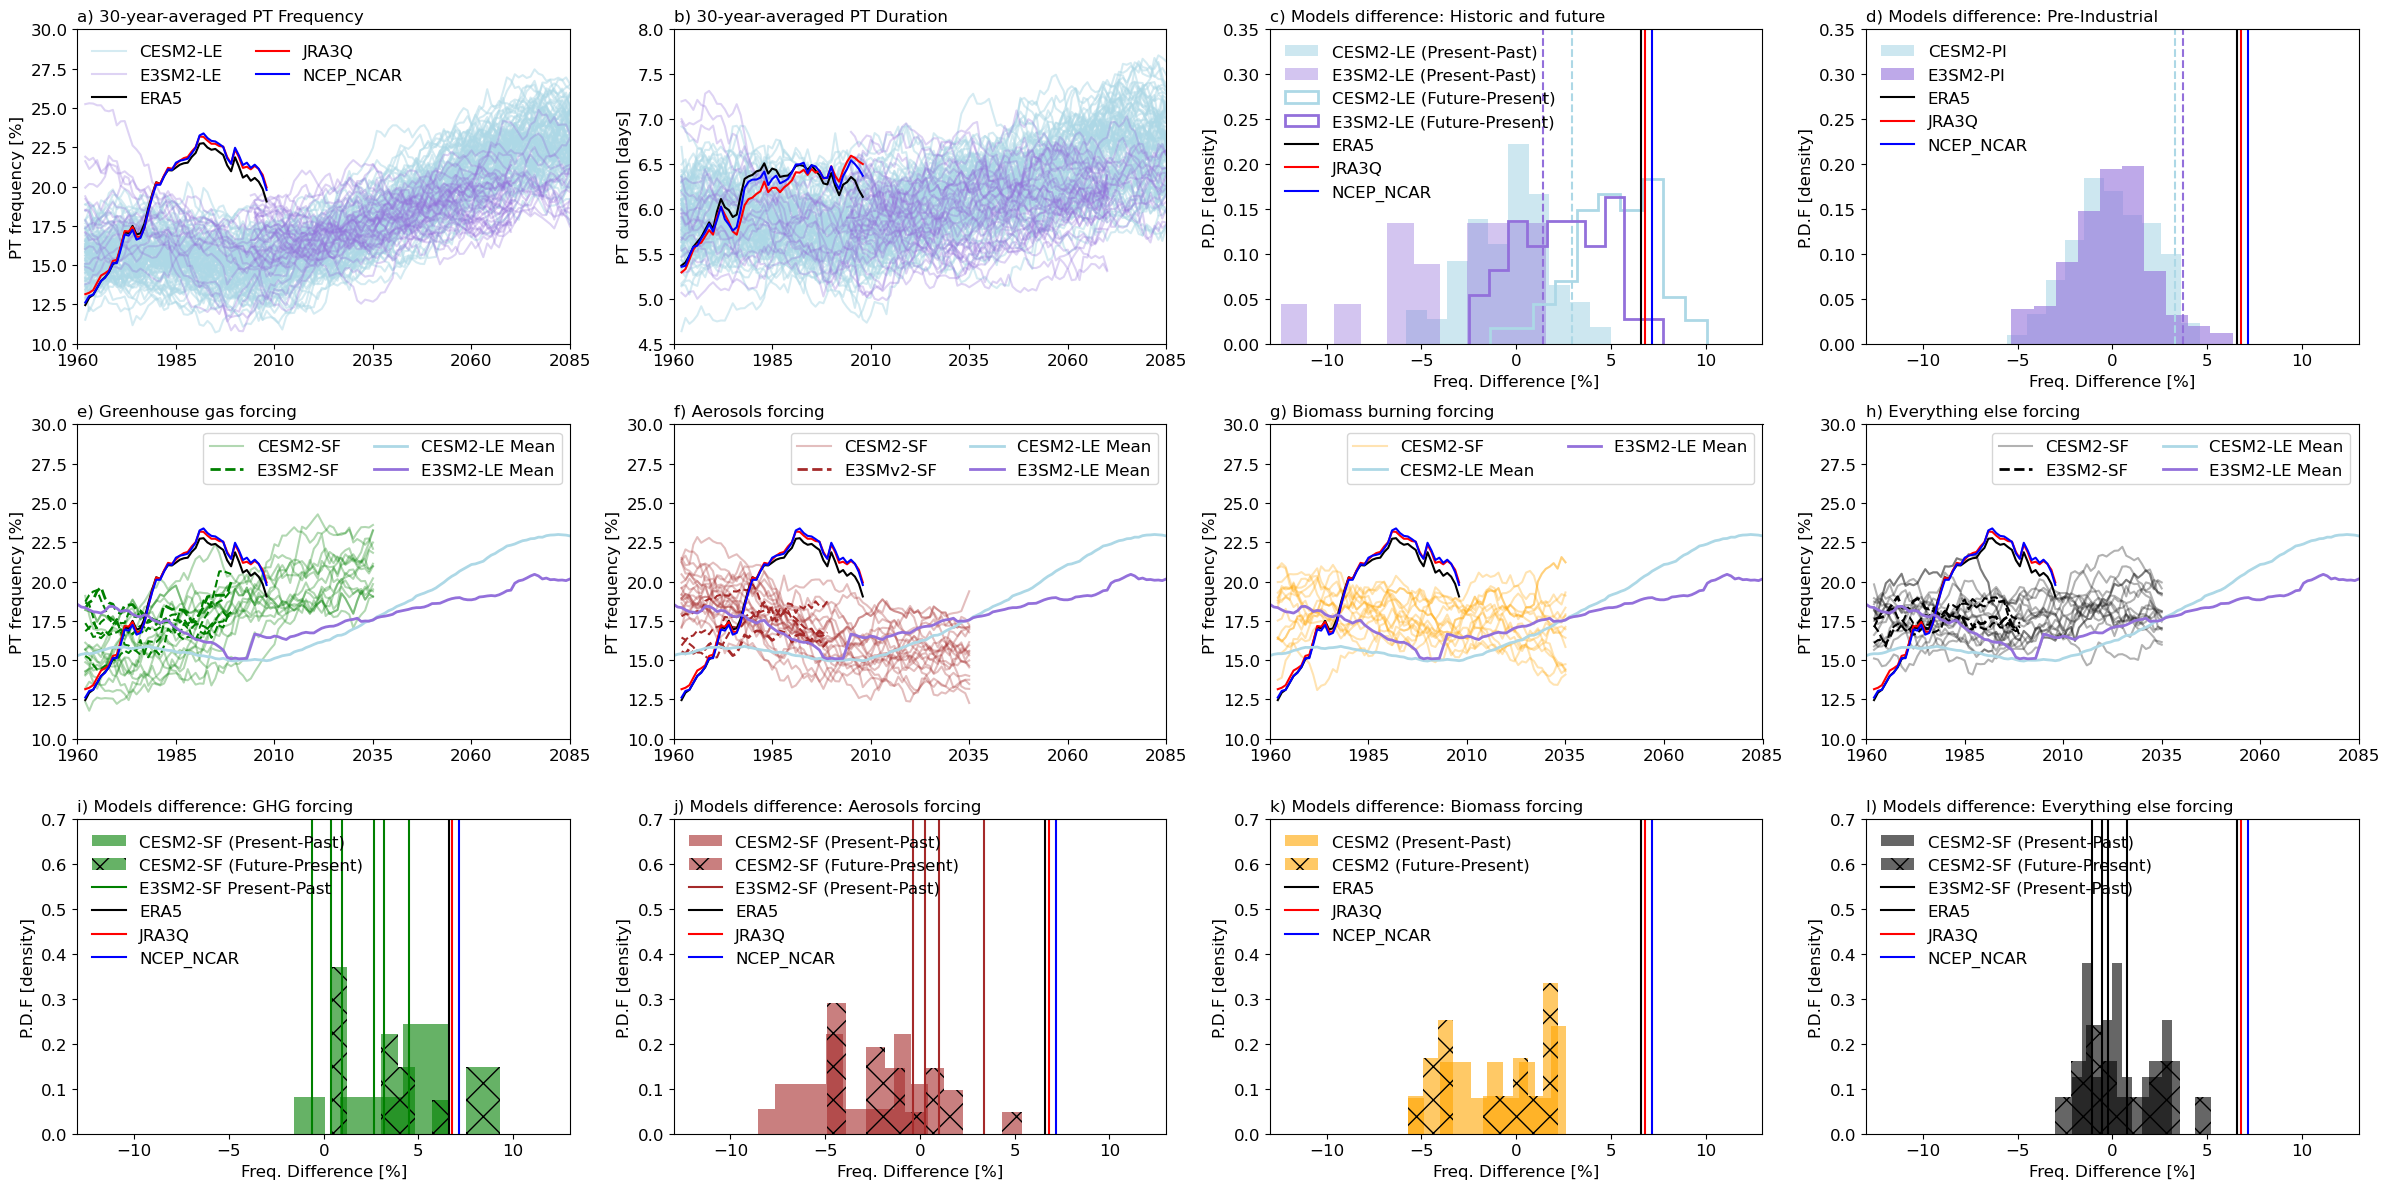

In [49]:
fig, axs = plt.subplots(3, 4, figsize=(24, 12))
axs_list = axs.flatten().tolist()
fontsize = 12
colors_forcings = ['brown','green','orange','black']
####### FREQ HIST ######
ax=axs_list[0]
for name_temp in names_models:
    ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='lightblue',alpha=0.5)
ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='lightblue',alpha=0.5,label='CESM2-LE')

for name_temp in names_models_e3smv2:
    ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='mediumpurple',alpha=0.3)
ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='mediumpurple',alpha=0.3,label='E3SM2-LE')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',label='ERA5')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red',label='JRA3Q')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue',label='NCEP_NCAR')
ax.legend(fontsize=fontsize,ncols=2,framealpha=0.0)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('a) 30-year-averaged PT Frequency',loc='left',fontsize=fontsize)

####### DUR HIST ######
ax=axs_list[1]
for name_temp in names_models:
    ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='lightblue',alpha=0.5)
ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='lightblue',alpha=0.5,label='CESM2-LE')

for name_temp in names_models_e3smv2:
    ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='mediumpurple',alpha=0.3)
ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='mediumpurple',alpha=0.3,label='E3SM2-LE')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='k',label='ERA5')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='red',label='JRA3Q')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='blue',label='NCEP_NCAR')
# ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(4.5,8)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT duration [days]',fontsize=fontsize)
ax.set_title('b) 30-year-averaged PT Duration',loc='left',fontsize=fontsize)

####### FREQ HIST HIST ######
ax=axs_list[2]

ax.hist(diffs_lens_past*100,alpha=0.6,label='CESM2-LE (Present-Past)',density=True,bins=10,color='lightblue')
ax.axvline(np.percentile(diffs_lens_past,95)*100,ls='--',color='lightblue')
ax.hist(diffs_e3sm_past*100,alpha=0.4,label='E3SM2-LE (Present-Past)',density=True,bins=10,color='mediumpurple')
ax.axvline(np.percentile(diffs_e3sm_past,95)*100,ls='--',color='mediumpurple')
# plt.hist(diffs_lens_future*100,alpha=0.3,label='LENS2 Frequency difference (2040-2069 vs. 1994-2023)',density=True)
# plt.hist(diffs_e3sm_future*100,alpha=0.3,label='E3SMv2 Frequency difference (2040-2069 vs. 1994-2023)',density=True)

ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)
    
ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.35)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,framealpha=0.0)
ax.set_title('c) Models difference: Historic and future',fontsize=fontsize,loc='left')

####### FREQ HIST Preindustrial ######
ax=axs_list[3]

ax.hist(diff_freqs_pi*100,alpha=0.6,label='CESM2-PI',density=True,bins=10,color='lightblue')
ax.axvline(np.percentile(diff_freqs_pi,95)*100,ls='--',color='lightblue')

ax.hist(diff_freqs_pi_e3smv2*100,alpha=0.6,label='E3SM2-PI',density=True,bins=10,color='mediumpurple')
ax.axvline(np.percentile(diff_freqs_pi_e3smv2,95)*100,ls='--',color='mediumpurple')

# ax.hist(diff_freqs_pi_cesm1hr*100,alpha=0.6,label='CESM1-HR-PI',density=True,bins=10,color='moccasin')
# ax.axvline(np.percentile(diff_freqs_pi_e3smv2,95)*100,ls='--',color='moccasin')

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)
    
ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.35)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,framealpha=0.0)
ax.set_title('d) Models difference: Pre-Industrial',fontsize=fontsize,loc='left')

####### Single forcing GHG ######
ax=axs_list[4]

for name_temp in names_models_sf:
    if 'GHG' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['GHG.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'GHG' in name_temp:
        if name_temp=='GHG.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['GHG.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=1,
                    ls ='--',label='E3SM2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=1,ls ='--')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=2,label='CESM2-LE Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SM2-LE Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('e) Greenhouse gas forcing',loc='left',fontsize=fontsize)

ax=axs_list[8]
forcing='GHG'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='green')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='green',hatch='x')

for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='green',label='E3SM2-SF Present-Past')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='green')

# ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
# ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('i) Models difference: GHG forcing',fontsize=fontsize,loc='left')

####### Single forcing AER ######
ax=axs_list[5]

for name_temp in names_models_sf:
    if 'AAER' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['AAER.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'AAER' in name_temp:
        if name_temp=='AAER.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['AAER.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=1,
                    ls ='--',label='E3SMv2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=1,ls ='--')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=2,label='CESM2-LE Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SM2-LE Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('f) Aerosols forcing',loc='left',fontsize=fontsize)

ax=axs_list[9]
forcing='AAER'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='brown')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='brown',hatch='x')

for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='brown',label='E3SM2-SF (Present-Past)')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='brown')

# ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
# ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('j) Models difference: Aerosols forcing',fontsize=fontsize,loc='left')

####### Single forcing BMB ######
ax=axs_list[6]

for name_temp in names_models_sf:
    if 'BMB' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='orange',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['BMB.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='orange',alpha=0.3,label='CESM2-SF')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=2,label='CESM2-LE Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SM2-LE Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('g) Biomass burning forcing',loc='left',fontsize=fontsize)

ax=axs_list[10]
forcing='BMB'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2 (Present-Past)',density=True,
        color='orange')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2 (Future-Present)',density=True,
        color='orange',hatch='x')

# ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
# ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('k) Models difference: Biomass forcing',fontsize=fontsize,loc='left')

####### Single forcing EE ######
ax=axs_list[7]

for name_temp in names_models_sf:
    if 'EE' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['EE.101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'EE' in name_temp:
        if name_temp=='EE.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['EE.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=1,
                    ls ='--',label='E3SM2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=1,ls ='--')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=2,label='CESM2-LE Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SM2-LE Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('h) Everything else forcing',loc='left',fontsize=fontsize)

ax=axs_list[11]
forcing='EE'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='black')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='black',hatch='x')


for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='k',label='E3SM2-SF (Present-Past)')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='k')
        
# ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
# ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)
        
for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_ylim(0,0.7)
ax.set_xlim(-13,13)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('l) Models difference: Everything else forcing',fontsize=fontsize,loc='left')

plt.tight_layout()
plt.savefig('nFigures/PT_Changes_Models.png',bbox_inches='tight')


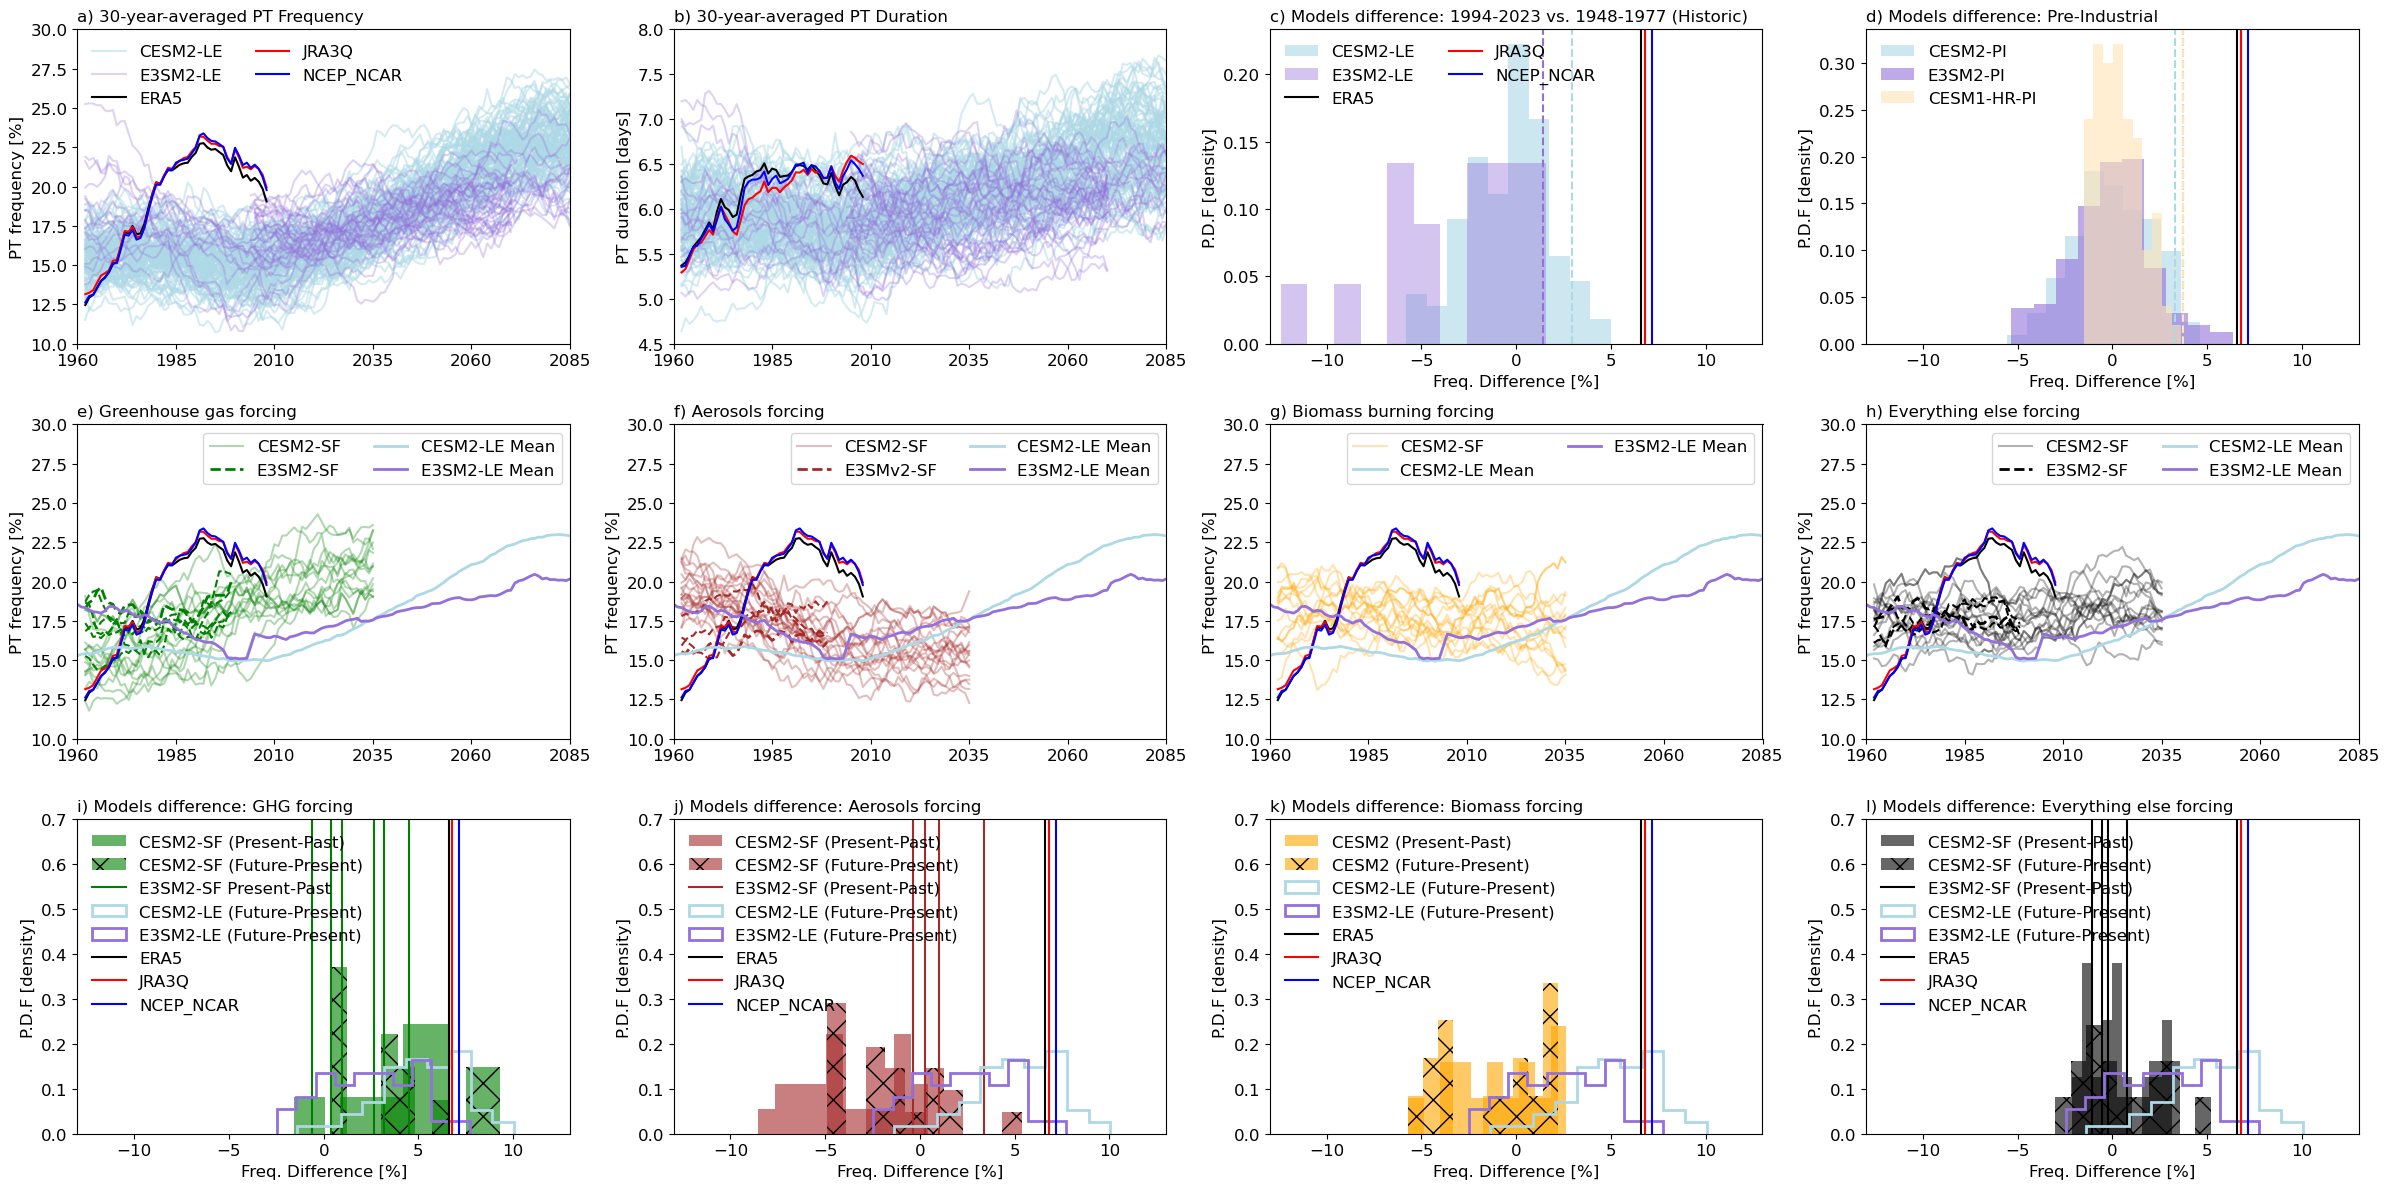

In [40]:
fig, axs = plt.subplots(3, 4, figsize=(24, 12))
axs_list = axs.flatten().tolist()
fontsize = 12
colors_forcings = ['brown','green','orange','black']
####### FREQ HIST ######
ax=axs_list[0]
for name_temp in names_models:
    ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='lightblue',alpha=0.5)
ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='lightblue',alpha=0.5,label='CESM2-LE')

for name_temp in names_models_e3smv2:
    ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='mediumpurple',alpha=0.3)
ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='mediumpurple',alpha=0.3,label='E3SM2-LE')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',label='ERA5')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red',label='JRA3Q')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue',label='NCEP_NCAR')
ax.legend(fontsize=fontsize,ncols=2,framealpha=0.0)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('a) 30-year-averaged PT Frequency',loc='left',fontsize=fontsize)

####### DUR HIST ######
ax=axs_list[1]
for name_temp in names_models:
    ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='lightblue',alpha=0.5)
ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='lightblue',alpha=0.5,label='CESM2-LE')

for name_temp in names_models_e3smv2:
    ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='mediumpurple',alpha=0.3)
ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='mediumpurple',alpha=0.3,label='E3SM2-LE')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='k',label='ERA5')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='red',label='JRA3Q')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='blue',label='NCEP_NCAR')
# ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(4.5,8)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT duration [days]',fontsize=fontsize)
ax.set_title('b) 30-year-averaged PT Duration',loc='left',fontsize=fontsize)

####### FREQ HIST HIST ######
ax=axs_list[2]

ax.hist(diffs_lens_past*100,alpha=0.6,label='CESM2-LE',density=True,bins=10,color='lightblue')
ax.axvline(np.percentile(diffs_lens_past,95)*100,ls='--',color='lightblue')
ax.hist(diffs_e3sm_past*100,alpha=0.4,label='E3SM2-LE',density=True,bins=10,color='mediumpurple')
ax.axvline(np.percentile(diffs_e3sm_past,95)*100,ls='--',color='mediumpurple')
# plt.hist(diffs_lens_future*100,alpha=0.3,label='LENS2 Frequency difference (2040-2069 vs. 1994-2023)',density=True)
# plt.hist(diffs_e3sm_future*100,alpha=0.3,label='E3SMv2 Frequency difference (2040-2069 vs. 1994-2023)',density=True)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)
    
ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=2,framealpha=0.0)
ax.set_title('c) Models difference: 1994-2023 vs. 1948-1977 (Historic)',fontsize=fontsize,loc='left')

####### FREQ HIST Preindustrial ######
ax=axs_list[3]

ax.hist(diff_freqs_pi*100,alpha=0.6,label='CESM2-PI',density=True,bins=10,color='lightblue')
ax.axvline(np.percentile(diff_freqs_pi,95)*100,ls='--',color='lightblue')

ax.hist(diff_freqs_pi_e3smv2*100,alpha=0.6,label='E3SM2-PI',density=True,bins=10,color='mediumpurple')
ax.axvline(np.percentile(diff_freqs_pi_e3smv2,95)*100,ls='--',color='mediumpurple')

ax.hist(diff_freqs_pi_cesm1hr*100,alpha=0.6,label='CESM1-HR-PI',density=True,bins=10,color='moccasin')
ax.axvline(np.percentile(diff_freqs_pi_e3smv2,95)*100,ls='--',color='moccasin')

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis])
    
ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,framealpha=0.0)
ax.set_title('d) Models difference: Pre-Industrial',fontsize=fontsize,loc='left')

####### Single forcing GHG ######
ax=axs_list[4]

for name_temp in names_models_sf:
    if 'GHG' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['GHG.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'GHG' in name_temp:
        if name_temp=='GHG.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['GHG.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=1,
                    ls ='--',label='E3SM2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=1,ls ='--')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=2,label='CESM2-LE Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SM2-LE Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('e) Greenhouse gas forcing',loc='left',fontsize=fontsize)

ax=axs_list[8]
forcing='GHG'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='green')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='green',hatch='x')

for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='green',label='E3SM2-SF Present-Past')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='green')

ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('i) Models difference: GHG forcing',fontsize=fontsize,loc='left')

####### Single forcing AER ######
ax=axs_list[5]

for name_temp in names_models_sf:
    if 'AAER' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['AAER.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'AAER' in name_temp:
        if name_temp=='AAER.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['AAER.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=1,
                    ls ='--',label='E3SMv2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=1,ls ='--')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=2,label='CESM2-LE Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SM2-LE Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('f) Aerosols forcing',loc='left',fontsize=fontsize)

ax=axs_list[9]
forcing='AAER'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='brown')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='brown',hatch='x')

for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='brown',label='E3SM2-SF (Present-Past)')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='brown')

ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('j) Models difference: Aerosols forcing',fontsize=fontsize,loc='left')

####### Single forcing BMB ######
ax=axs_list[6]

for name_temp in names_models_sf:
    if 'BMB' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='orange',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['BMB.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='orange',alpha=0.3,label='CESM2-SF')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=2,label='CESM2-LE Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SM2-LE Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('g) Biomass burning forcing',loc='left',fontsize=fontsize)

ax=axs_list[10]
forcing='BMB'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2 (Present-Past)',density=True,
        color='orange')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2 (Future-Present)',density=True,
        color='orange',hatch='x')

ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('k) Models difference: Biomass forcing',fontsize=fontsize,loc='left')

####### Single forcing EE ######
ax=axs_list[7]

for name_temp in names_models_sf:
    if 'EE' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['EE.101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'EE' in name_temp:
        if name_temp=='EE.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['EE.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=1,
                    ls ='--',label='E3SM2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=1,ls ='--')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(meanlens2*100,color='lightblue',lw=2,label='CESM2-LE Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SM2-LE Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('h) Everything else forcing',loc='left',fontsize=fontsize)

ax=axs_list[11]
forcing='EE'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='black')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='black',hatch='x')


for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='k',label='E3SM2-SF (Present-Past)')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='k')
        
ax.hist(diffs_lens_future*100,alpha=1,label='CESM2-LE (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SM2-LE (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)
        
for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_ylim(0,0.7)
ax.set_xlim(-13,13)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('l) Models difference: Everything else forcing',fontsize=fontsize,loc='left')

plt.tight_layout()
# plt.savefig('Figures/3_ChangesModelWorld_v2.png',bbox_inches='tight')


# Figure for Qiang Fu

In [39]:
freq_no_pdo = pd.read_csv('freq_no_pdo.csv',index_col=0)

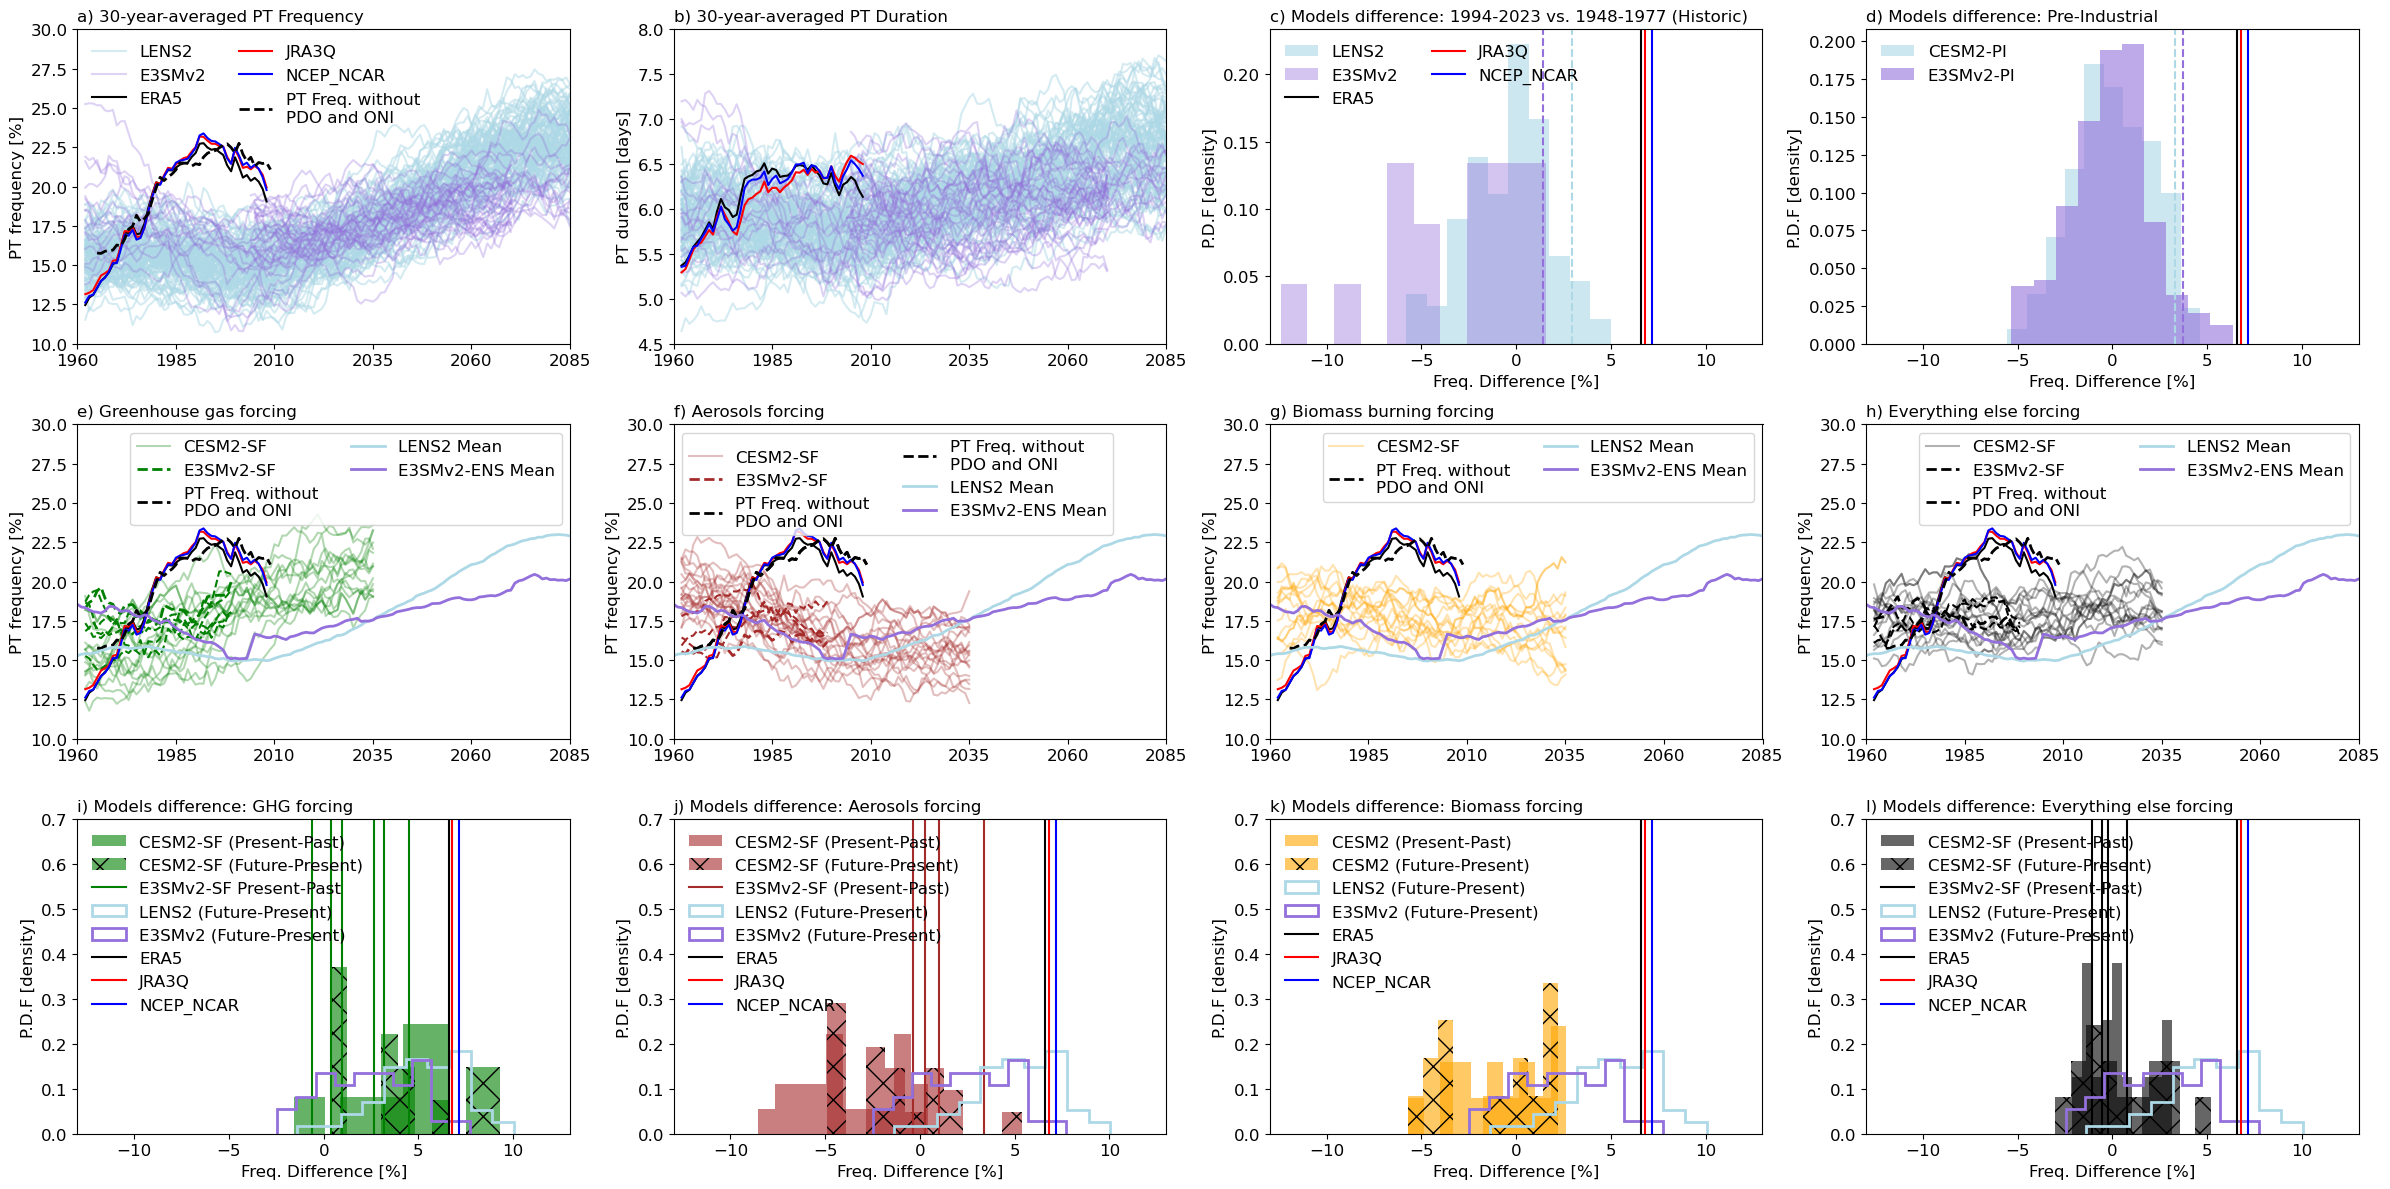

In [44]:
fig, axs = plt.subplots(3, 4, figsize=(24, 12))
axs_list = axs.flatten().tolist()
fontsize = 12
colors_forcings = ['brown','green','orange','black']
####### FREQ HIST ######
ax=axs_list[0]
for name_temp in names_models:
    ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='lightblue',alpha=0.5)
ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='lightblue',alpha=0.5,label='LENS2')

for name_temp in names_models_e3smv2:
    ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='mediumpurple',alpha=0.3)
ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='mediumpurple',alpha=0.3,label='E3SMv2')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',label='ERA5')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red',label='JRA3Q')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue',label='NCEP_NCAR')

ax.plot(freq_no_pdo.loc['1948':].rolling(30,center=True).mean(),color='black',
             label='PT Freq. without\nPDO and ONI',ls='--',lw=2)

ax.legend(fontsize=fontsize,ncols=2,framealpha=0.0)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('a) 30-year-averaged PT Frequency',loc='left',fontsize=fontsize)

####### DUR HIST ######
ax=axs_list[1]
for name_temp in names_models:
    ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='lightblue',alpha=0.5)
ax.plot(dic_stats_durations_lens2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='lightblue',alpha=0.5,label='LENS2')

for name_temp in names_models_e3smv2:
    ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='mediumpurple',alpha=0.3)
ax.plot(dic_stats_durations_e3smv2[name_temp][f'wr{wr}']['mean'].loc[f'{start_year}':],color='mediumpurple',alpha=0.3,label='E3SMv2')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='k',label='ERA5')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='red',label='JRA3Q')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['mean'].loc[f'{start_year}':],color='blue',label='NCEP_NCAR')
# ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(4.5,8)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT duration [days]',fontsize=fontsize)
ax.set_title('b) 30-year-averaged PT Duration',loc='left',fontsize=fontsize)

####### FREQ HIST HIST ######
ax=axs_list[2]

ax.hist(diffs_lens_past*100,alpha=0.6,label='LENS2',density=True,bins=10,color='lightblue')
ax.axvline(np.percentile(diffs_lens_past,95)*100,ls='--',color='lightblue')
ax.hist(diffs_e3sm_past*100,alpha=0.4,label='E3SMv2',density=True,bins=10,color='mediumpurple')
ax.axvline(np.percentile(diffs_e3sm_past,95)*100,ls='--',color='mediumpurple')
# plt.hist(diffs_lens_future*100,alpha=0.3,label='LENS2 Frequency difference (2040-2069 vs. 1994-2023)',density=True)
# plt.hist(diffs_e3sm_future*100,alpha=0.3,label='E3SMv2 Frequency difference (2040-2069 vs. 1994-2023)',density=True)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)
    
ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=2,framealpha=0.0)
ax.set_title('c) Models difference: 1994-2023 vs. 1948-1977 (Historic)',fontsize=fontsize,loc='left')

####### FREQ HIST Preindustrial ######
ax=axs_list[3]

ax.hist(diff_freqs_pi*100,alpha=0.6,label='CESM2-PI',density=True,bins=10,color='lightblue')
ax.axvline(np.percentile(diff_freqs_pi,95)*100,ls='--',color='lightblue')

ax.hist(diff_freqs_pi_e3smv2*100,alpha=0.6,label='E3SMv2-PI',density=True,bins=10,color='mediumpurple')
ax.axvline(np.percentile(diff_freqs_pi_e3smv2,95)*100,ls='--',color='mediumpurple')

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis])
    
ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,framealpha=0.0)
ax.set_title('d) Models difference: Pre-Industrial',fontsize=fontsize,loc='left')

####### Single forcing GHG ######
ax=axs_list[4]

for name_temp in names_models_sf:
    if 'GHG' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['GHG.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'GHG' in name_temp:
        if name_temp=='GHG.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['GHG.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=1,
                    ls ='--',label='E3SMv2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='green',alpha=1,ls ='--')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(freq_no_pdo.loc['1948':].rolling(30,center=True).mean(),color='black',
             label='PT Freq. without\nPDO and ONI',ls='--',lw=2)

ax.plot(meanlens2*100,color='lightblue',lw=2,label='LENS2 Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SMv2-ENS Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('e) Greenhouse gas forcing',loc='left',fontsize=fontsize)

ax=axs_list[8]
forcing='GHG'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='green')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='green',hatch='x')

for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='green',label='E3SMv2-SF Present-Past')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='green')

ax.hist(diffs_lens_future*100,alpha=1,label='LENS2 (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SMv2 (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('i) Models difference: GHG forcing',fontsize=fontsize,loc='left')

####### Single forcing AER ######
ax=axs_list[5]

for name_temp in names_models_sf:
    if 'AAER' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['AAER.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'AAER' in name_temp:
        if name_temp=='AAER.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['AAER.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=1,
                    ls ='--',label='E3SMv2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='brown',alpha=1,ls ='--')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(freq_no_pdo.loc['1948':].rolling(30,center=True).mean(),color='black',
             label='PT Freq. without\nPDO and ONI',ls='--',lw=2)

ax.plot(freq_no_pdo.loc['1948':].rolling(30,center=True).mean(),color='black',
             label='PT Freq. without\nPDO and ONI',ls='--',lw=2)
ax.plot(meanlens2*100,color='lightblue',lw=2,label='LENS2 Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SMv2-ENS Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('f) Aerosols forcing',loc='left',fontsize=fontsize)

ax=axs_list[9]
forcing='AAER'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='brown')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='brown',hatch='x')

for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='brown',label='E3SMv2-SF (Present-Past)')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='brown')

ax.hist(diffs_lens_future*100,alpha=1,label='LENS2 (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SMv2 (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('j) Models difference: Aerosols forcing',fontsize=fontsize,loc='left')

####### Single forcing BMB ######
ax=axs_list[6]

for name_temp in names_models_sf:
    if 'BMB' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='orange',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['BMB.001'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='orange',alpha=0.3,label='CESM2-SF')

ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(freq_no_pdo.loc['1948':].rolling(30,center=True).mean(),color='black',
             label='PT Freq. without\nPDO and ONI',ls='--',lw=2)

ax.plot(meanlens2*100,color='lightblue',lw=2,label='LENS2 Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SMv2-ENS Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('g) Biomass burning forcing',loc='left',fontsize=fontsize)

ax=axs_list[10]
forcing='BMB'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2 (Present-Past)',density=True,
        color='orange')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2 (Future-Present)',density=True,
        color='orange',hatch='x')

ax.hist(diffs_lens_future*100,alpha=1,label='LENS2 (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SMv2 (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)

for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_xlim(-13,13)
ax.set_ylim(0,0.7)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('k) Models difference: Biomass forcing',fontsize=fontsize,loc='left')

####### Single forcing EE ######
ax=axs_list[7]

for name_temp in names_models_sf:
    if 'EE' in name_temp:
        ax.plot(dic_stats_durations_lens2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=0.3)
ax.plot(dic_stats_durations_lens2_sf['EE.101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=0.3,label='CESM2-SF')

for name_temp in names_models_e3smv2_sf:
    if 'EE' in name_temp:
        if name_temp=='EE.0101':
            ax.plot(dic_stats_durations_e3smv2_sf['EE.0101'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=1,
                    ls ='--',label='E3SMv2-SF',lw=2)
        else:
            ax.plot(dic_stats_durations_e3smv2_sf[name_temp][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k',alpha=1,ls ='--')


ax.plot(dic_stats_durations['ERA5'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='k')
ax.plot(dic_stats_durations['JRA3Q'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='red')
ax.plot(dic_stats_durations['NCEP_NCAR'][f'wr{wr}']['n_days'].loc[f'{start_year}':]*100,color='blue')
ax.plot(freq_no_pdo.loc['1948':].rolling(30,center=True).mean(),color='black',
             label='PT Freq. without\nPDO and ONI',ls='--',lw=2)
ax.plot(meanlens2*100,color='lightblue',lw=2,label='LENS2 Mean')
ax.plot(meane3smv2*100,color='mediumpurple',lw=2,label='E3SMv2-ENS Mean')

ax.legend(fontsize=fontsize,ncols=2)
ax.set_ylim(10,30)
# ax.legend(fontsize=fontsize)
ax.set_xticks(np.arange(1975-15,2101-15,25))
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlim(1975-15,2100-15)
ax.set_ylabel('PT frequency [%]',fontsize=fontsize)
ax.set_title('h) Everything else forcing',loc='left',fontsize=fontsize)

ax=axs_list[11]
forcing='EE'
ax.hist(dic_diffs_forcings_past[forcing]*100,alpha=0.6,label=f'CESM2-SF (Present-Past)',density=True,
        color='black')
ax.hist(dic_diffs_forcings_future[forcing]*100,alpha=0.6,label=f'CESM2-SF (Future-Present)',density=True,
        color='black',hatch='x')


for i in range(len(dic_diffs_forcings_past_e3smv2[forcing])):
    if i==len(dic_diffs_forcings_past_e3smv2[forcing])-1:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='k',label='E3SMv2-SF (Present-Past)')
    else:
        ax.axvline(dic_diffs_forcings_past_e3smv2[forcing][i]*100,color='k')
        
ax.hist(diffs_lens_future*100,alpha=1,label='LENS2 (Future-Present)',density=True,color='lightblue',histtype='step',lw=2)
ax.hist(diffs_e3sm_future*100,alpha=1,label='E3SMv2 (Future-Present)',density=True,color='mediumpurple',histtype='step',lw=2)
        
for reanalysis in names_reanalyses:
    ax.axvline(dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][end_year]*100 -\
        dic_stats_durations[reanalysis][f'wr{wr}']['n_days'][start_year]*100,
               color=colors_reanalyses[reanalysis],label=reanalysis)

ax.set_xlabel('Freq. Difference [%]',fontsize=fontsize)
ax.set_ylabel('P.D.F [density]',fontsize=fontsize)
ax.set_ylim(0,0.7)
ax.set_xlim(-13,13)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize,ncols=1,loc='upper left',framealpha=0.0)
ax.set_title('l) Models difference: Everything else forcing',fontsize=fontsize,loc='left')

plt.tight_layout()
plt.savefig('Figures/3_ChangesModelWorld_QiangFu.png',bbox_inches='tight')